# Classification

Goal: To predict:

- if a driver is going to receive a tip

### Load Necessary Packages and Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import col, count, to_timestamp, split, dayofweek, year, lit, month, date_format, hour, when
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, Bucketizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from functools import reduce
import matplotlib.pyplot as plt

### Set up PySpark Environment 

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName('TaxiTipPrediction').getOrCreate()

23/11/27 06:42:56 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
# for item in spark.sparkContext.getConf().getAll():
#     print(item)

### Load Raw Data

In [4]:
df = spark.read.parquet("gs://msca-bdp-student-gcs/chicago-taxi-trips-data/*.parquet",inferSchema=True)

In [5]:
# Cast the appropriate columns to the correct data types
df = df.withColumn("trip_start_timestamp", to_timestamp(col("trip_start_timestamp"), "yyyy-MM-ddHH:mm:ss")) \
       .withColumn("trip_end_timestamp", to_timestamp(col("trip_end_timestamp"), "yyyy-MM-ddHH:mm:ss")) \
       .withColumn("trip_seconds", col("trip_seconds").cast(IntegerType())) \
       .withColumn("trip_miles", col("trip_miles").cast(DoubleType())) \
       .withColumn("fare", col("fare").cast(DoubleType())) \
       .withColumn("tips", col("tips").cast(DoubleType())) \
       .withColumn("tolls", col("tolls").cast(DoubleType())) \
       .withColumn("extras", col("extras").cast(DoubleType())) \
       .withColumn("trip_total", col("trip_total").cast(DoubleType())) \
       .withColumn("pickup_latitude", col("pickup_latitude").cast(DoubleType())) \
       .withColumn("pickup_longitude", col("pickup_longitude").cast(DoubleType())) \
       .withColumn("dropoff_latitude", col("dropoff_latitude").cast(DoubleType())) \
       .withColumn("dropoff_longitude", col("dropoff_longitude").cast(DoubleType()))

In [6]:
df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+---------------------+----------------------+------------------+------------------+--------------------+------------------+------------------+------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+--------------------+
|summary|          unique_key|             taxi_id|      trip_seconds|        trip_miles| pickup_census_tract|dropoff_census_tract|pickup_community_area|dropoff_community_area|              fare|              tips|               tolls|            extras|        trip_total|payment_type|             company|    pickup_latitude|   pickup_longitude|     pickup_location|   dropoff_latitude| dropoff_longitude|    dropoff_location|
+-------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+-----------

The chosen dataset consists of the following fields:

- `unique_key` : Unique identifier for the trip.
- `taxi_id` : A unique identifier for the taxi.
- `trip_start_timestamp`: When the trip started, rounded to the nearest 15 minutes.
- `trip_end_timestamp`: When the trip ended, rounded to the nearest 15 minutes.
- `trip_seconds`: Time of the trip in seconds.
- `trip_miles`: Distance of the trip in miles.
- `pickup_census_tract`: The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips.
- `dropoff_census_tract`: The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips.
- `pickup_community_area`: The Community Area where the trip began.
- `dropoff_community_area`: The Community Area where the trip ended.
- `fare`: The fare for the trip.
- `tips`: The tip for the trip. Cash tips generally will not be recorded.
- `tolls`: The tolls for the trip.
- `extras`: Extra charges for the trip.
- `trip_total`: Total cost of the trip, the total of the fare, tips, tolls, and extras.
- `payment_type`: Type of payment for the trip.
- `company`: The taxi company.
- `pickup_latitude`: The latitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
- `pickup_longitude`: The longitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
- `pickup_location`: The location of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
- `dropoff_latitude`: The latitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.
- `dropoff_longitude`: The longitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.
- `dropoff_location`: The location of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.

## I.Data Preprocessing

### a. Data Cleaning

In [7]:
# Calculate null percentage for each column
total_rows = df.count()
null_percentage = df.select([
    (count(when(col(c).isNull(), c)) / total_rows * 100).alias(c) 
    for c in df.columns
])
null_percentage.show()

+----------+-------+--------------------+-------------------+------------------+--------------------+-------------------+--------------------+---------------------+----------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|unique_key|taxi_id|trip_start_timestamp| trip_end_timestamp|      trip_seconds|          trip_miles|pickup_census_tract|dropoff_census_tract|pickup_community_area|dropoff_community_area|                fare|                tips|             tolls|              extras|          trip_total|payment_type|           company|   pickup_latitude|  pickup_longitude|   pickup_location|  dropoff_latitude| dropoff_longitude|  dropoff_location|
+----------+-------+--------------------+-------------------+------------------+--------------------+-------------------+-----

In [8]:
#Drop columns after initial exploration
df = df.drop("pickup_census_tract","dropoff_census_tract")

In [9]:
# Filter out records where all fields are not null
non_null_df = df.filter(~reduce(lambda a, b: a | b, (col(x).isNull() for x in df.columns)))

In [10]:
total_useful_rows = non_null_df.count()
print("Original dataset record counts: ",total_rows)
print("Not-null record counts: ",total_useful_rows)

Original dataset record counts:  210662630
Not-null record counts:  124591048


### b. EDA

#### Plot Hour of the Day for trip_start_timestamp

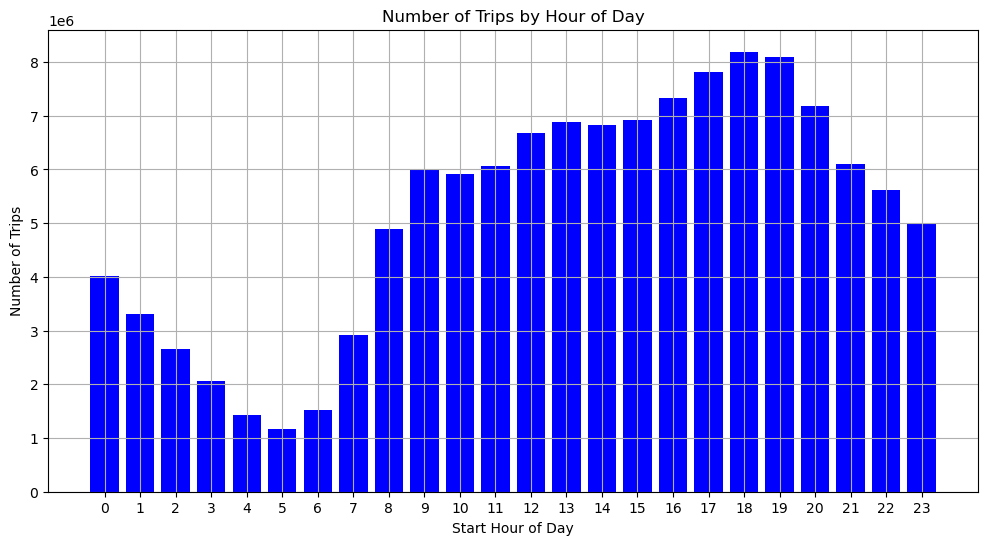

In [11]:
# Extract hour from trip_start_timestamp
non_null_df = non_null_df.withColumn("start_hour_of_day", hour("trip_start_timestamp"))

# Aggregate data by hour_of_day
hourly_count = non_null_df.groupBy("start_hour_of_day").count().orderBy("start_hour_of_day")

# Collect the data to the driver
hourly_data = hourly_count.collect()

# Extract hours and counts
hours = [row['start_hour_of_day'] for row in hourly_data]
counts = [row['count'] for row in hourly_data]

plt.figure(figsize=(12, 6))
plt.bar(hours, counts, color='blue')
plt.xlabel('Start Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Hour of Day')
plt.xticks(hours)
plt.grid()
plt.show()

Consider one-hot encoding of hour of day

#### Plot Hour of the Day for trip_end_timestamp

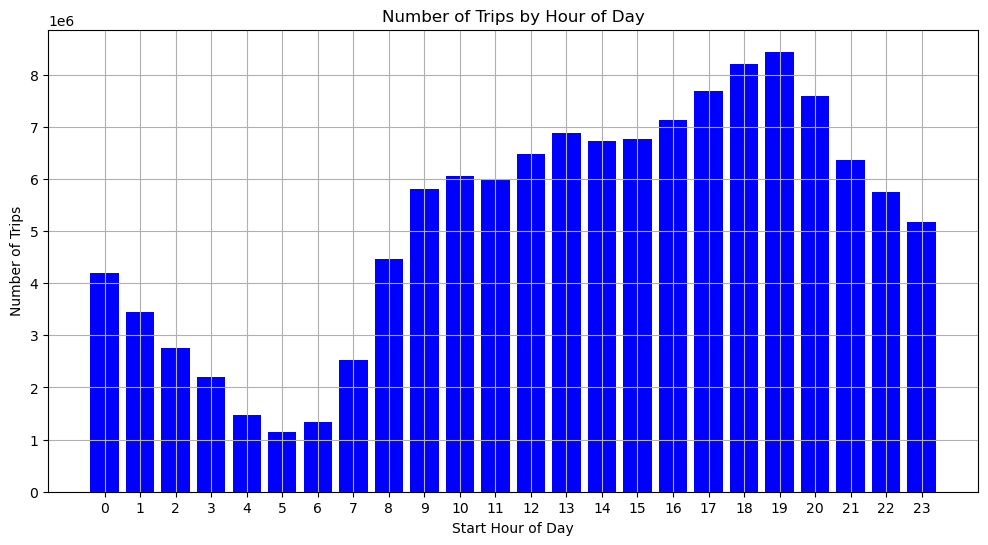

In [12]:
# Extract hour from trip_start_timestamp
non_null_df = non_null_df.withColumn("end_hour_of_day", hour("trip_end_timestamp"))

# Aggregate data by hour_of_day
hourly_count = non_null_df.groupBy("end_hour_of_day").count().orderBy("end_hour_of_day")

# Collect the data to the driver
hourly_data = hourly_count.collect()

# Extract hours and counts
hours = [row['end_hour_of_day'] for row in hourly_data]
counts = [row['count'] for row in hourly_data]

plt.figure(figsize=(12, 6))
plt.bar(hours, counts, color='blue')
plt.xlabel('Start Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Hour of Day')
plt.xticks(hours)
plt.grid()
plt.show()

Also consider one-hot encoding

#### Distribution of trip_seconds

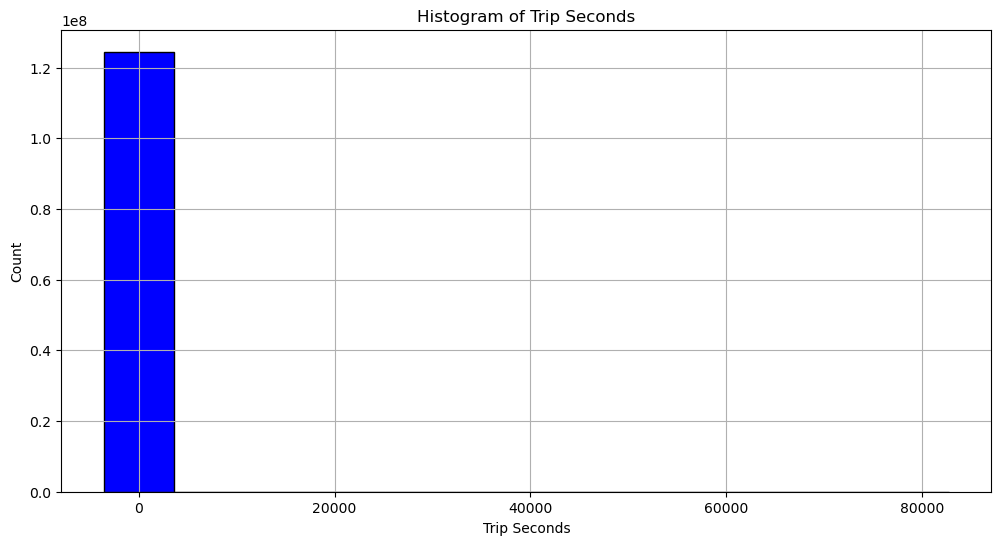

In [13]:
# Create a histogram of trip_seconds
trip_seconds_histogram = non_null_df.select('trip_seconds').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = trip_seconds_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Trip Seconds')
plt.ylabel('Count')
plt.title('Histogram of Trip Seconds')
plt.grid()
plt.show()

Remove outliers, keep only those trips that are less than 12000 seconds

In [14]:
non_null_df = non_null_df.filter(non_null_df['trip_seconds'] < 12000)

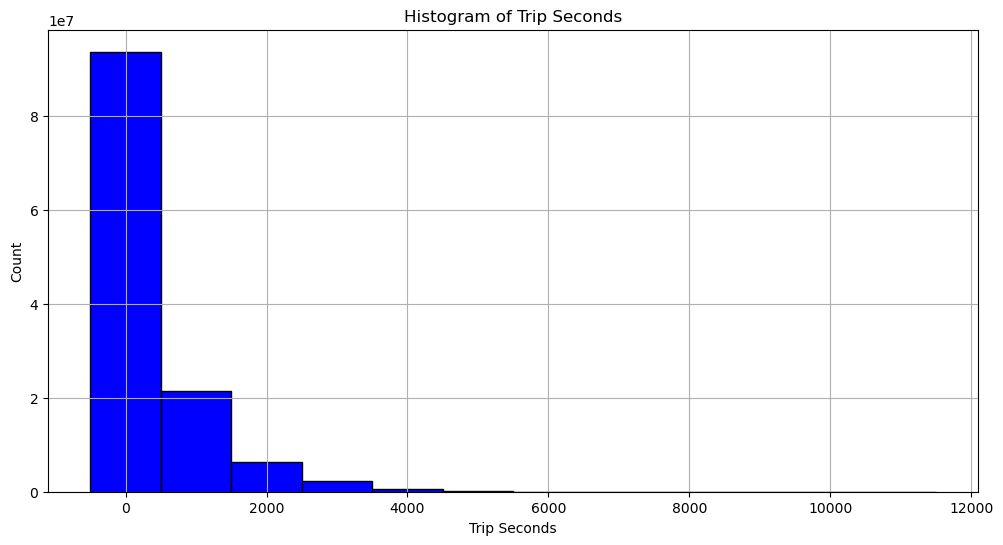

In [15]:
# Create a histogram of trip_seconds
trip_seconds_histogram = non_null_df.select('trip_seconds').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = trip_seconds_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Trip Seconds')
plt.ylabel('Count')
plt.title('Histogram of Trip Seconds')
plt.grid()
plt.show()

Consider log-transformation

#### Distribution of trip_miles

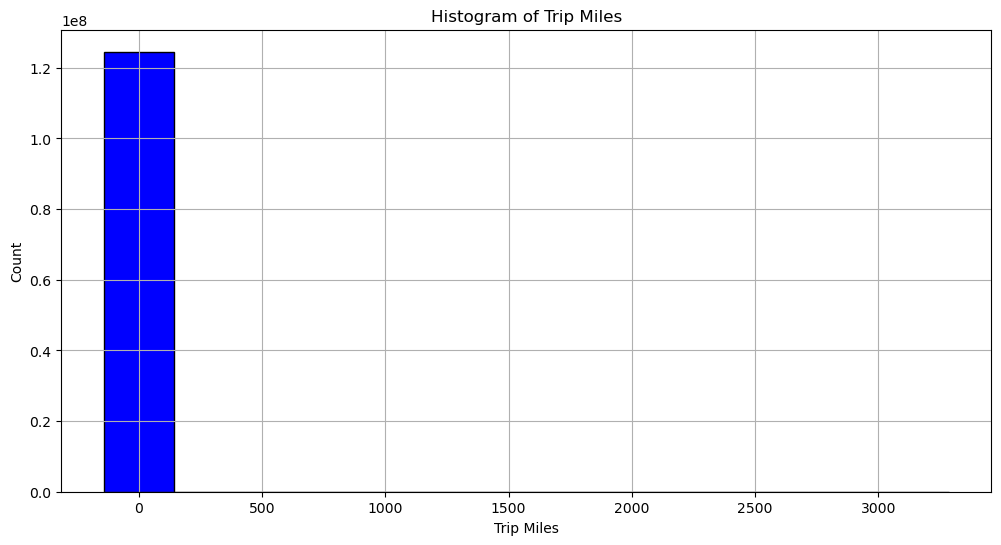

In [16]:
# Create a histogram of trip_miles
trip_miles_histogram = non_null_df.select('trip_miles').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = trip_miles_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Trip Miles')
plt.ylabel('Count')
plt.title('Histogram of Trip Miles')
plt.grid()
plt.show()

Remove outliers, keep only those trips that are less than 100 miles

In [17]:
non_null_df = non_null_df.filter(non_null_df['trip_miles'] < 50)

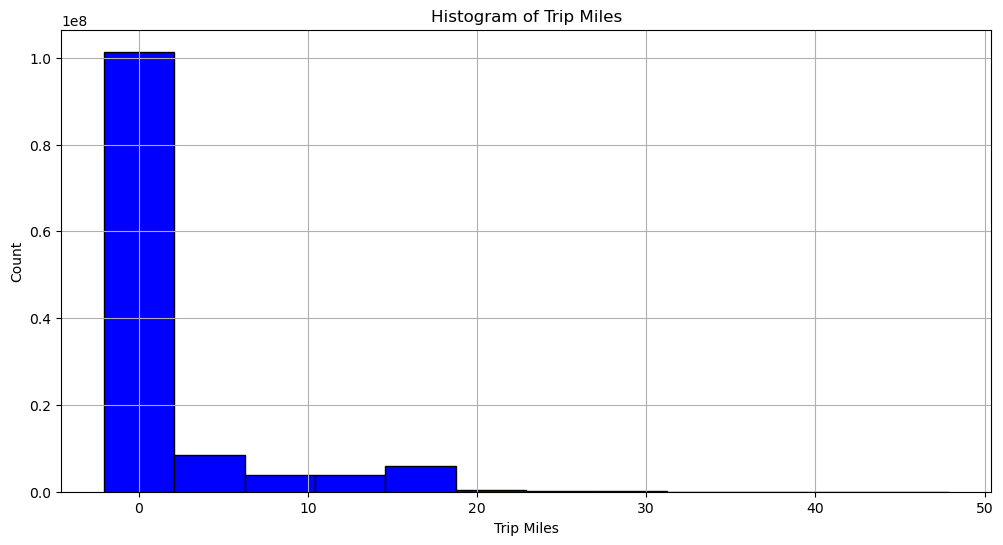

In [18]:
# Create a histogram of trip_miles
trip_miles_histogram = non_null_df.select('trip_miles').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = trip_miles_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Trip Miles')
plt.ylabel('Count')
plt.title('Histogram of Trip Miles')
plt.grid()
plt.show()

Consider log-transformation

#### pickup_community_area

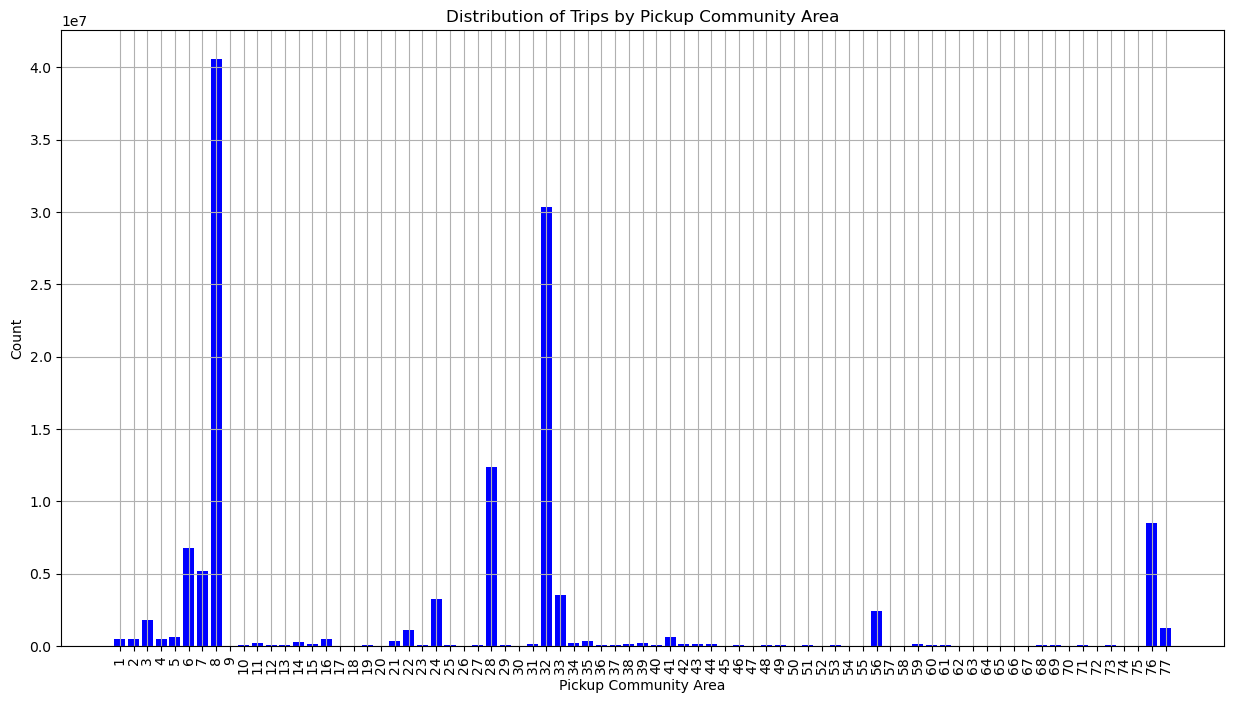

In [19]:
# Count the occurrences of each pickup_community_area
area_counts = non_null_df.groupBy("pickup_community_area").count().orderBy("pickup_community_area")

# Collect the data
area_data = area_counts.collect()

# Extract areas and counts
areas = [row['pickup_community_area'] for row in area_data]
counts = [row['count'] for row in area_data]

plt.figure(figsize=(15, 8))
plt.bar(areas, counts, color='blue')
plt.xlabel('Pickup Community Area')
plt.ylabel('Count')
plt.title('Distribution of Trips by Pickup Community Area')
plt.xticks(areas, rotation='vertical')
plt.grid()
plt.show()

#### dropoff_community_area

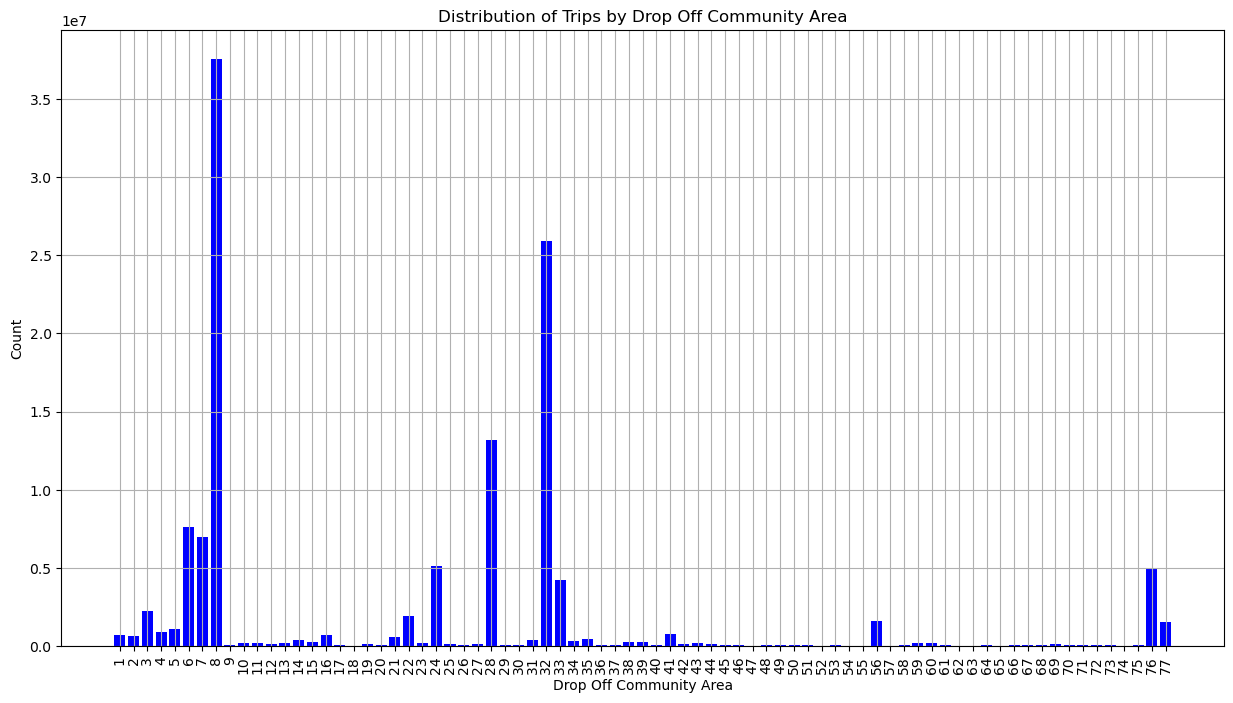

In [20]:
# Count the occurrences of each pickup_community_area
area_counts = non_null_df.groupBy("dropoff_community_area").count().orderBy("dropoff_community_area")

# Collect the data
area_data = area_counts.collect()

# Extract areas and counts
areas = [row['dropoff_community_area'] for row in area_data]
counts = [row['count'] for row in area_data]

plt.figure(figsize=(15, 8))
plt.bar(areas, counts, color='blue')
plt.xlabel('Drop Off Community Area')
plt.ylabel('Count')
plt.title('Distribution of Trips by Drop Off Community Area')
plt.xticks(areas, rotation='vertical')
plt.grid()
plt.show()

#### fare

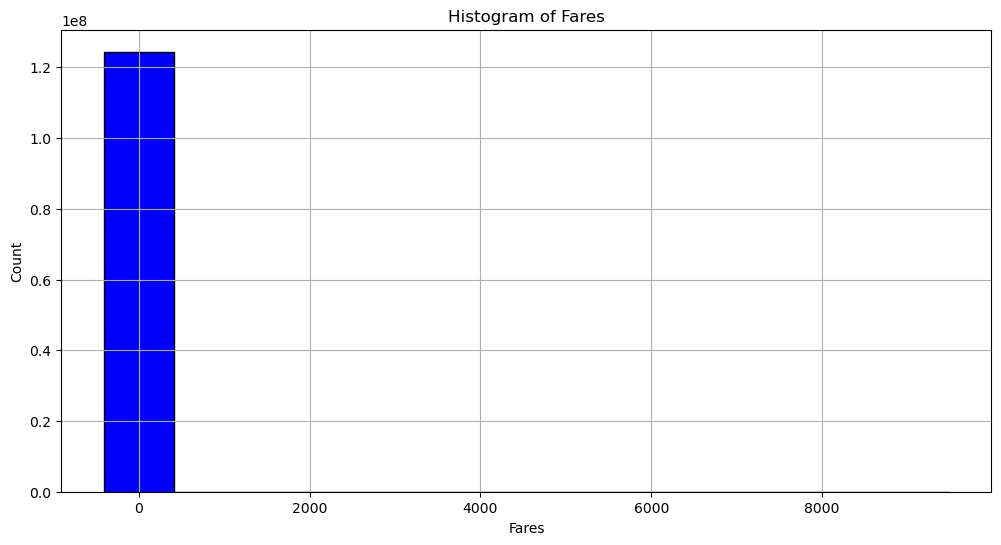

In [21]:
# Create a histogram of trip_seconds
fare_histogram = non_null_df.select('fare').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = fare_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Fares')
plt.ylabel('Count')
plt.title('Histogram of Fares')
plt.grid()
plt.show()

Remove outliers, keep only fares below 200. 

In [22]:
non_null_df = non_null_df.filter(non_null_df['fare'] < 200)

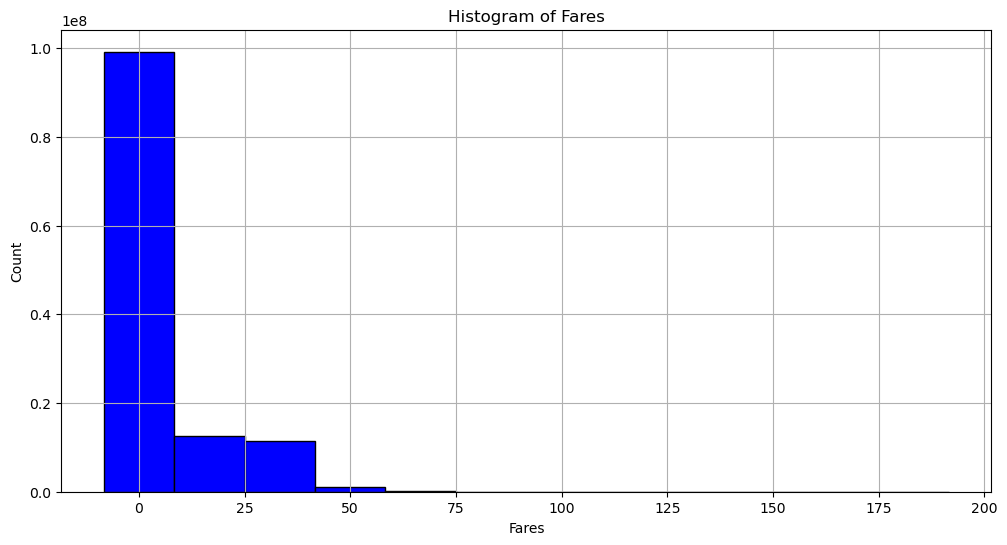

In [23]:
# Create a histogram of trip_seconds
fare_histogram = non_null_df.select('fare').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = fare_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Fares')
plt.ylabel('Count')
plt.title('Histogram of Fares')
plt.grid()
plt.show()

Right skewed. Consider log-transformation

#### tips

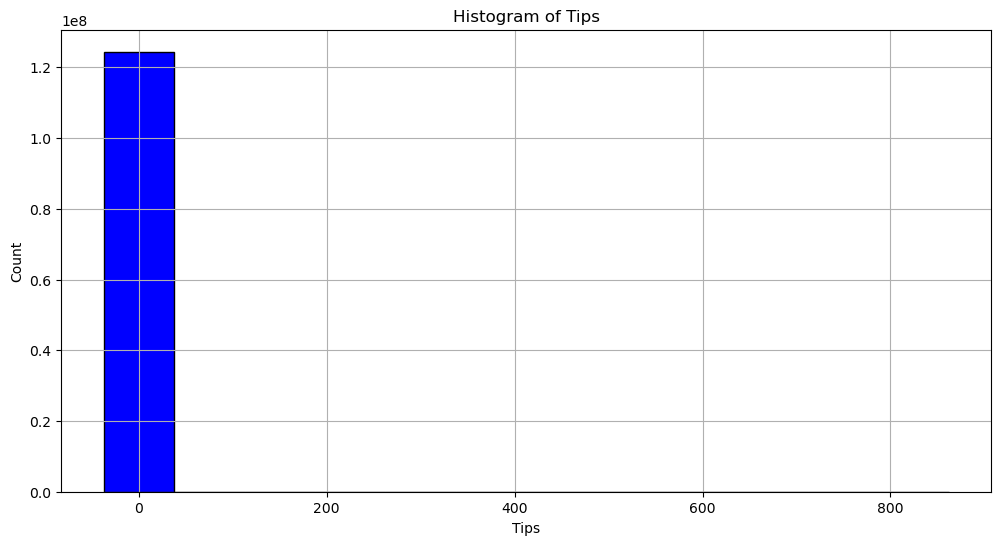

In [24]:
# Create a histogram of trip_seconds
tip_histogram = non_null_df.select('tips').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = tip_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Tips')
plt.ylabel('Count')
plt.title('Histogram of Tips')
plt.grid()
plt.show()

No Preprocessing Necessary. Will be used to create target variable.

#### tolls

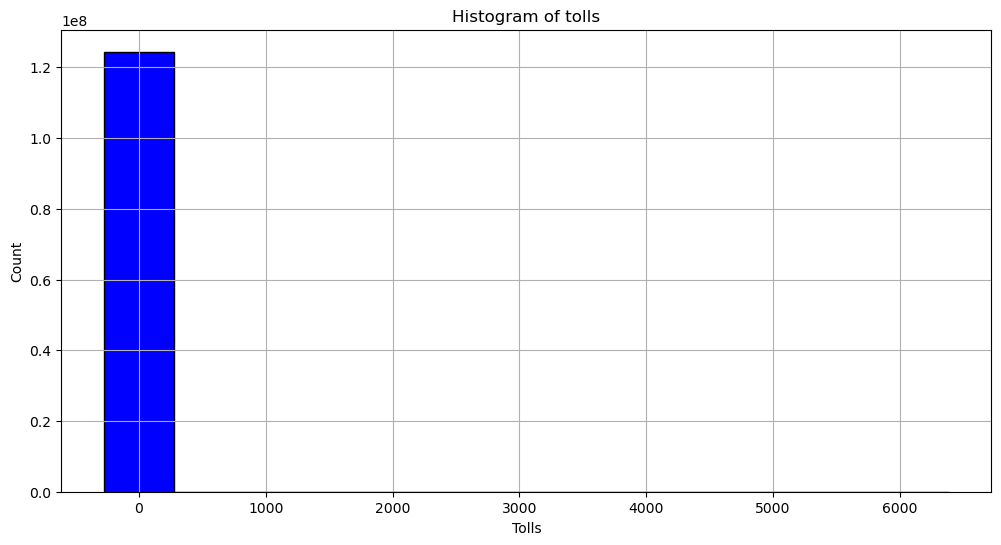

In [25]:
# Create a histogram of trip_seconds
toll_histogram = non_null_df.select('tolls').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = toll_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Tolls')
plt.ylabel('Count')
plt.title('Histogram of tolls')
plt.grid()
plt.show()

In [26]:
non_null_df = non_null_df.filter(non_null_df['tolls'] < 10)

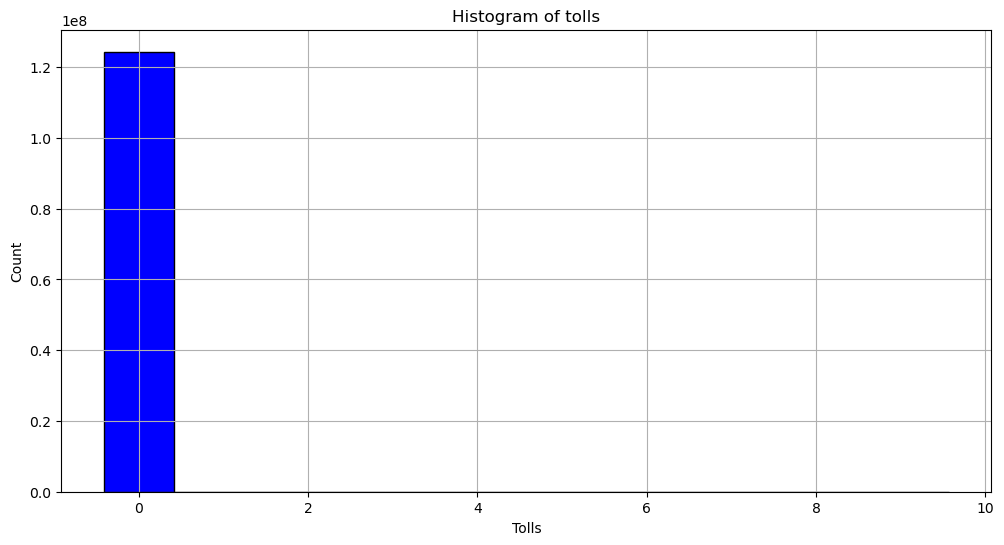

In [27]:
# Create a histogram of trip_seconds
toll_histogram = non_null_df.select('tolls').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = toll_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Tolls')
plt.ylabel('Count')
plt.title('Histogram of tolls')
plt.grid()
plt.show()

#### extras

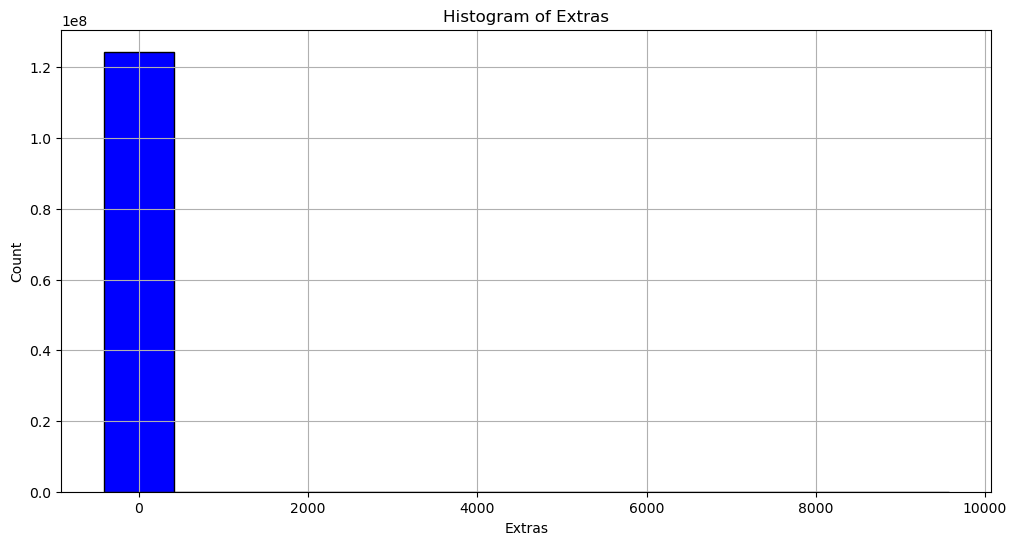

In [28]:
# Create a histogram of trip_seconds
extras_histogram = non_null_df.select('extras').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = extras_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Extras')
plt.ylabel('Count')
plt.title('Histogram of Extras')
plt.grid()
plt.show()

In [29]:
non_null_df = non_null_df.filter(non_null_df['extras'] < 100)

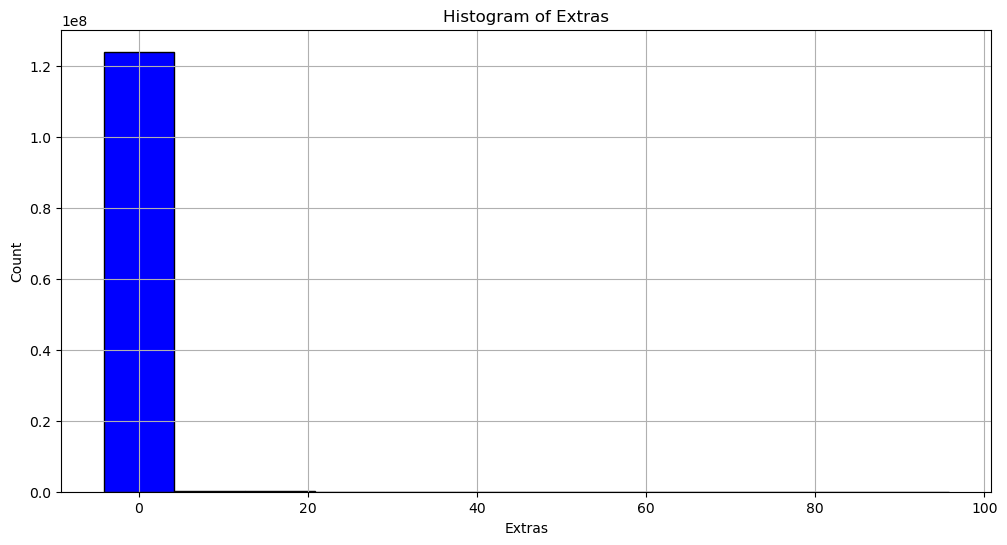

In [30]:
# Create a histogram of trip_seconds
extras_histogram = non_null_df.select('extras').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = extras_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Extras')
plt.ylabel('Count')
plt.title('Histogram of Extras')
plt.grid()
plt.show()

#### trip_total

In [44]:
# Add a new column that calculates the sum of fare, tips, tolls, and extras
non_null_df = non_null_df.withColumn('calculated_total', col('fare') + col('tips') + col('tolls') + col('extras'))

# Add another column to check if trip_total matches the calculated total
non_null_df = non_null_df.withColumn('is_total_correct', col('trip_total') == col('calculated_total'))

# Count the number of True and False values
true_false_counts = non_null_df.groupBy("is_total_correct").count()

# Show the counts
true_false_counts.show()

+----------------+---------+
|is_total_correct|    count|
+----------------+---------+
|            true|102885120|
|           false| 19756877|
+----------------+---------+



Consider drop rows where it's false.

In [45]:
non_null_df = non_null_df.filter(non_null_df['is_total_correct'])

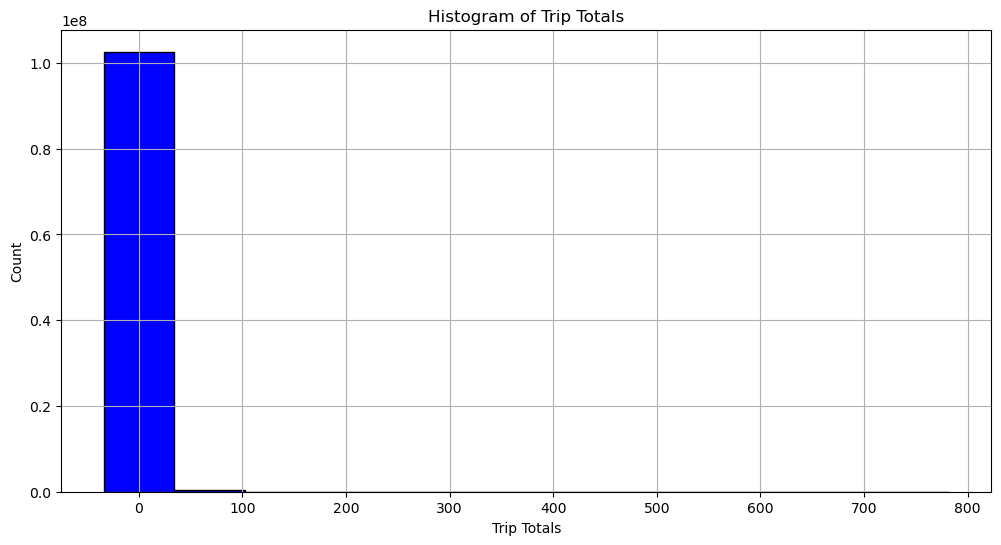

In [46]:
# Create a histogram of trip_total
total_histogram = non_null_df.select('trip_total').rdd.flatMap(lambda x: x).histogram(12)

# Unpack the results
bin_edges, bin_counts = total_histogram

# Calculate the bin widths (for plotting)
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], bin_counts, width=bin_widths, color='blue', edgecolor='black')
plt.xlabel('Trip Totals')
plt.ylabel('Count')
plt.title('Histogram of Trip Totals')
plt.grid()
plt.show()

#### payment_type

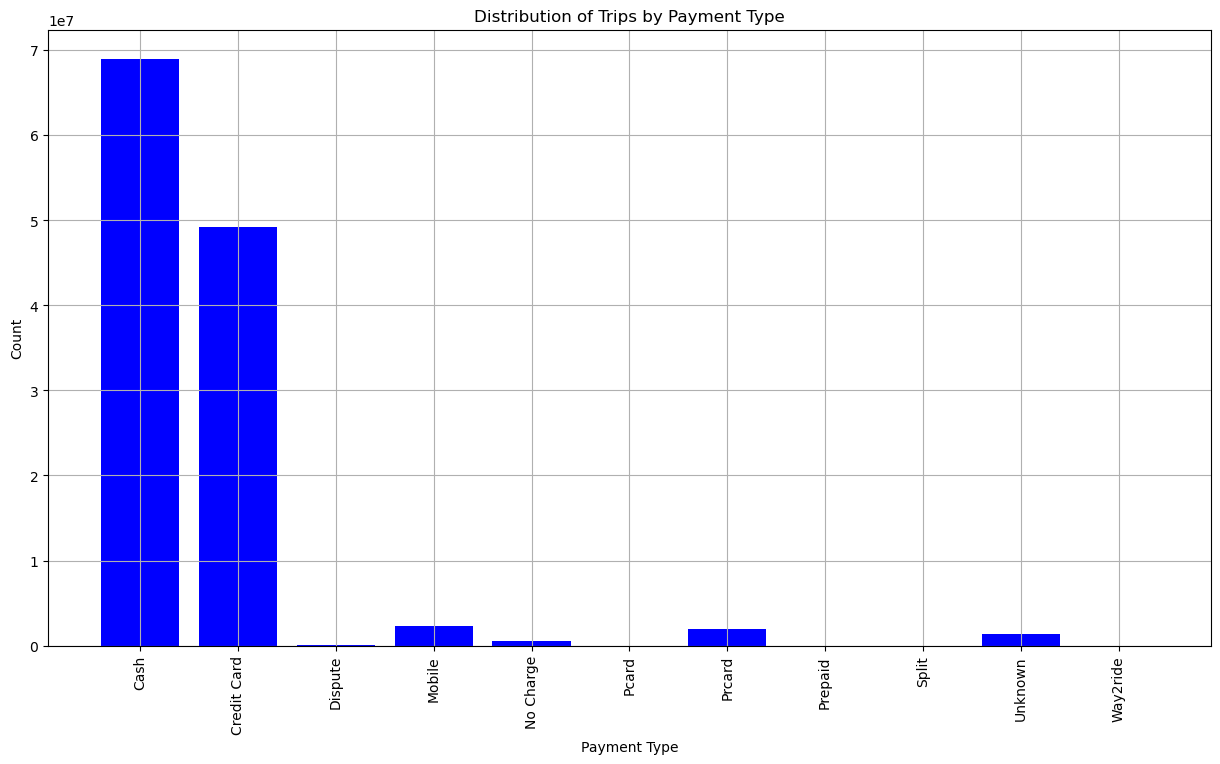

In [33]:
# Count the occurrences of each pickup_community_area
payment_type_counts = non_null_df.groupBy("payment_type").count().orderBy("payment_type")

# Collect the data
payment_data = payment_type_counts.collect()

# Extract areas and counts
areas = [row['payment_type'] for row in payment_data]
counts = [row['count'] for row in payment_data]

plt.figure(figsize=(15, 8))
plt.bar(areas, counts, color='blue')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.title('Distribution of Trips by Payment Type')
plt.xticks(areas, rotation='vertical')
plt.grid()
plt.show()

Consider One-hot Encoding

#### company

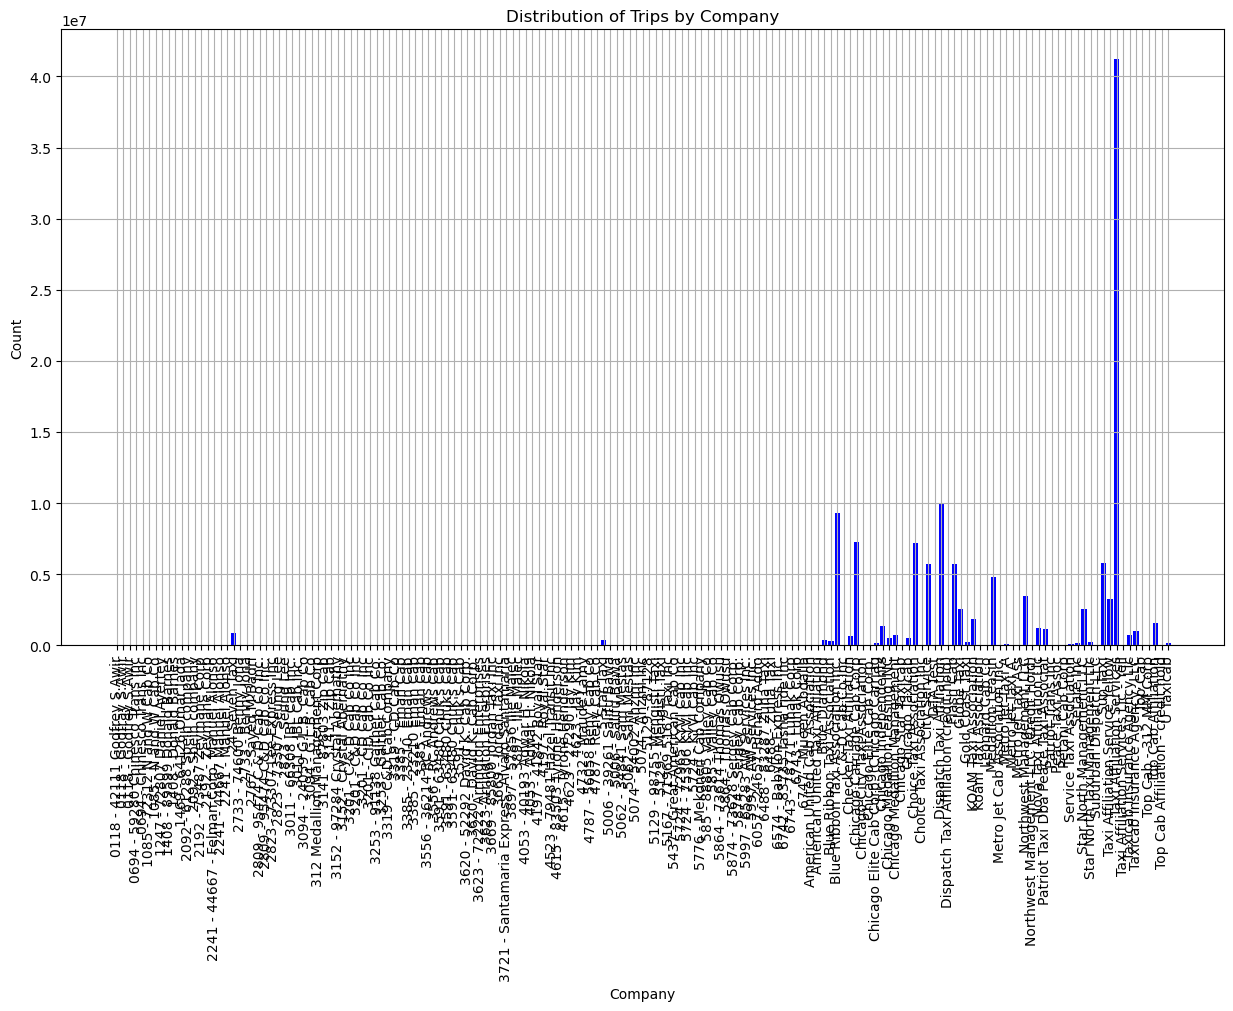

In [36]:
# Count the occurrences of each pickup_community_area
company_counts = non_null_df.groupBy("company").count().orderBy("company")

# Collect the data
company_data = company_counts.collect()

# Extract areas and counts
areas = [row['company'] for row in company_data]
counts = [row['count'] for row in company_data]

plt.figure(figsize=(15, 8))
plt.bar(areas, counts, color='blue')
plt.xlabel('Company')
plt.ylabel('Count')
plt.title('Distribution of Trips by Company')
plt.xticks(areas, rotation='vertical')
plt.grid()
plt.show()

Keep only the 30 biggest companies.

In [37]:
# Determine the number of top companies you want to keep
N = 30 

# Sort the company_counts DataFrame in descending order and take the top N
top_companies = company_counts.orderBy('count', ascending=False).limit(N)

# Collect the top company names
top_company_names = [row['company'] for row in top_companies.collect()]

# Filter the original DataFrame to keep only rows where the company is in the top companies
non_null_df = non_null_df.filter(non_null_df['company'].isin(top_company_names))

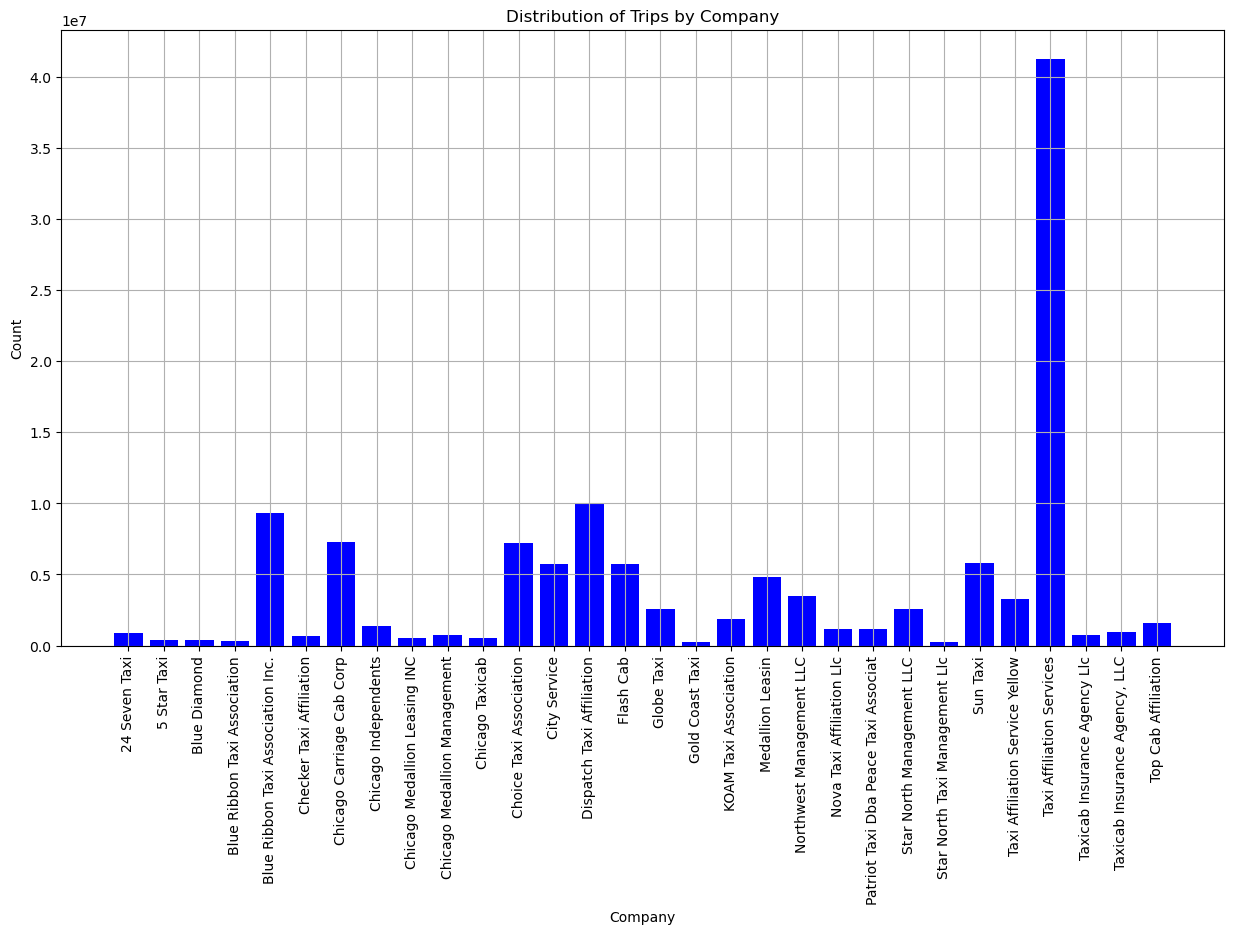

In [38]:
# Count the occurrences of each pickup_community_area
company_counts = non_null_df.groupBy("company").count().orderBy("company")

# Collect the data
company_data = company_counts.collect()

# Extract areas and counts
areas = [row['company'] for row in company_data]
counts = [row['count'] for row in company_data]

plt.figure(figsize=(15, 8))
plt.bar(areas, counts, color='blue')
plt.xlabel('Company')
plt.ylabel('Count')
plt.title('Distribution of Trips by Company')
plt.xticks(areas, rotation='vertical')
plt.grid()
plt.show()

## II. Feature Engineering

In [47]:
# Select columns where it is known for a taxi driver before a trip starts

### a. Create Target Variable

## III. Data Splitting

In [32]:
# # Data Splitting
# train_data, test_data = df.randomSplit([0.7, 0.3])

## IV. Model Building

## V. Hyperparameter Tuning

## VI. Model Evaluation

## VII. Conclusions